In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from glob import glob as glob
import os
import pywt
import cv2
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm

/Users/Rafferino/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# num_class = 15
# num_train = 20
# num_test = 5
im_size = np.array((192, 168))

In [3]:
def filter_files(fnames, cond, size=5):
    fnames_base = [os.path.basename(i)[:-4] for i in fnames]
    acc_files = []
    for i, f in enumerate(fnames_base):
        az = int(f[12:16])
        elev = int(f[17:20])
        if cond(az, elev):
#             print(az, elev)
            acc_files.append(fnames[i])
#     samps = np.random.choice(acc_files, size, replace=False)
    return acc_files

def fread(f):
    return plt.imread(f).flatten().T

def random_sample_cond(train_cond, test_cond):
    
    all_fnames = glob("*/*/*_P00A*.pgm")
    
    train_fnames = filter_files(all_fnames, train_cond) 
    test_fnames = filter_files(all_fnames, test_cond)
    
    num_train = len(train_fnames)
    num_test = len(test_fnames)
    
    A = np.zeros((np.prod(im_size), num_train))
    y = np.zeros((np.prod(im_size), num_test))
    
    train_gt = np.zeros(num_train).astype(int)
    test_gt = np.zeros(num_test).astype(int)
    
    for i, f in enumerate(train_fnames):
        A[:,i] = fread(f)
        train_gt[i] = int(os.path.basename(f)[5:7])-1
        
    for i, f in enumerate(test_fnames):
        y[:,i] = fread(f)
        test_gt[i] = int(os.path.basename(f)[5:7])-1
            
    return A, y, train_gt, test_gt, (train_fnames, test_fnames)

def random_sample():
    all_fnames = glob("*/*/*_P00A*.pgm")
    half = len(all_fnames)//2
    np.random.shuffle(all_fnames)
    
    train_fnames = all_fnames[:half]
    test_fnames = all_fnames[half:]
    
    A = np.zeros((np.prod(im_size), len(train_fnames)))
    y = np.zeros((np.prod(im_size), len(test_fnames)))
    
    train_gt = np.zeros(len(train_fnames)).astype(int)
    test_gt = np.zeros(len(test_fnames)).astype(int)
    
    for i, f in enumerate(train_fnames):
        A[:,i] = fread(f)
        train_gt[i] = int(os.path.basename(f)[5:7])-1
        
    for i, f in enumerate(test_fnames):
        y[:,i] = fread(f)
        test_gt[i] = int(os.path.basename(f)[5:7])-1
        
    return A, y, train_gt, test_gt, (train_fnames, test_fnames)

In [4]:
A, y, train_gt, test_gt, names = random_sample()
print(A.shape, y.shape)
print(train_gt)
print(test_gt)

(32256, 1207) (32256, 1207)
[29 23  0 ... 30 10 32]
[ 6 25 14 ...  1 18  2]


In [5]:
names[0]

['CroppedYale/yaleB30/yaleB30_P00A-060E+20.pgm',
 'CroppedYale/yaleB24/yaleB24_P00A+000E+00.pgm',
 'CroppedYale/yaleB01/yaleB01_P00A-130E+20.pgm',
 'CroppedYale/yaleB28/yaleB28_P00A+020E-10.pgm',
 'CroppedYale/yaleB20/yaleB20_P00A-085E-20.pgm',
 'CroppedYale/yaleB05/yaleB05_P00A+110E+40.pgm',
 'CroppedYale/yaleB35/yaleB35_P00A-010E+00.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A-050E+00.pgm',
 'CroppedYale/yaleB17/yaleB17_P00A-005E+10.pgm',
 'CroppedYale/yaleB02/yaleB02_P00A+000E+00.pgm',
 'CroppedYale/yaleB34/yaleB34_P00A-110E+15.pgm',
 'CroppedYale/yaleB12/yaleB12_P00A+005E+10.pgm',
 'CroppedYale/yaleB07/yaleB07_P00A+130E+20.pgm',
 'CroppedYale/yaleB13/yaleB13_P00A+020E-40.pgm',
 'CroppedYale/yaleB06/yaleB06_P00A+000E-35.pgm',
 'CroppedYale/yaleB02/yaleB02_P00A-060E+20.pgm',
 'CroppedYale/yaleB08/yaleB08_P00A-130E+20.pgm',
 'CroppedYale/yaleB02/yaleB02_P00A-085E-20.pgm',
 'CroppedYale/yaleB27/yaleB27_P00A+085E-20.pgm',
 'CroppedYale/yaleB30/yaleB30_P00A+110E+40.pgm',
 'CroppedYale/yaleB2

In [142]:
def down_samp(A, ds_factor=16):
    im_size_down = np.ceil(im_size/ds_factor).astype(int)
    A_down = np.zeros((np.prod(im_size_down), A.shape[-1]))
#     print(A_down.shape)
    for i in range(A.shape[-1]):
        A_down[:,i] = A[:,i].reshape(im_size)[::ds_factor, ::ds_factor].flatten()
    return A_down, im_size_down

In [94]:
def down_samp_pca(A, dim=132):
    # sklearn PCA
    pca = PCA(n_components=dim, svd_solver="auto")
    A_pca = pca.fit_transform(A.T).T
    
    # Manual PCA
#     U, S, Vh = np.linalg.svd(A, full_matrices=True)
#     print(U.shape, S.shape, Vh.shape)
#     A_pca = U[:,:dim].T@A
    return A_pca, pca

In [ ]:
def down(A, x, down_samp_func):
    return down_samp_func(A,x)

In [95]:
pywt.wavedec2(A.reshape((*im_size,-1)), 'haar', axes=(0,1), level=1)[1][1].shape

(96, 84, 719)

In [143]:
def down_samp_wave(A, level=4):
    im_vec = A.reshape((*im_size,-1))
    wave_vec = pywt.wavedec2(im_vec, 'haar', axes=(0,1), level=level)
#     low_dim_data = wave_vec[0]
    low_dim_data = ((wave_vec[0] + sum(wave_vec[1]))/4)
#     low_dim_data = wave_vec[0] + sum(wave_vec[1])
    shape = low_dim_data.shape[:2]
    low_dim_data = low_dim_data.reshape(-1, A.shape[-1])
    quantized_data = (low_dim_data/np.max(low_dim_data, axis=0)*255).astype(np.uint8)
    return quantized_data, shape

In [97]:
def down_samp_cv(A):
    A_down = np.zeros((120, A.shape[-1]))
    for i in range(A.shape[-1]):
        A_down[:,i] = cv2.resize(A[:,i].reshape(im_size), (12,10)).flatten()
    return A_down, (12,10)

In [13]:
A_ds, ds_shape = down_samp(A, ds_factor=16)

In [14]:
A_wave, wave_shape = down_samp_wave(A)

In [15]:
A_ds_cv, ds_cv_shape = down_samp_cv(A)

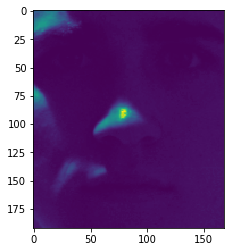

In [16]:
plt.imshow(A[...,0].reshape(im_size))

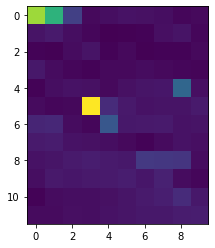

In [17]:
plt.imshow(A_ds_cv[...,0].reshape(ds_cv_shape))

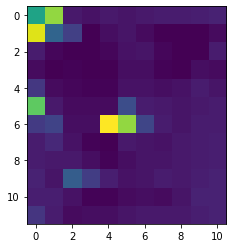

In [18]:
plt.imshow(A_ds[...,0].reshape(ds_shape))

In [19]:
A_wave.shape

(8064, 1207)

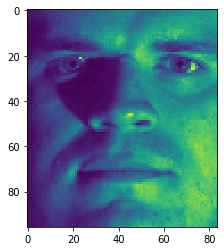

In [20]:
plt.imshow(A_wave[...,1].reshape(wave_shape))

In [146]:
A_pca, _ = down_samp_pca(A)

In [147]:
A_pca.shape

(132, 719)

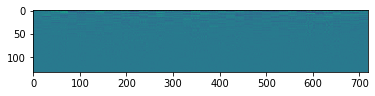

In [148]:
plt.imshow(A_pca)

In [24]:
# def delta(x, i):
#     assert i < num_class
#     out = np.zeros(len(x))
#     idxs = slice(i*num_class, i*num_class+num_train)
#     out[idxs] = x[idxs]
#     return out

In [10]:
def delta_i(x, i, gt):
    return np.where(gt==i, x, 0)

In [185]:
@ignore_warnings(category=ConvergenceWarning)
def identity(A, y, class_idxs, lmbda=1e-12):
    A_norm = np.linalg.norm(A, axis=0)
    y_norm = np.linalg.norm(y)
#     print(A, y)
    prob = Lasso(fit_intercept=False, alpha=lmbda, max_iter=1e3)
#     prob = LassoCV(fit_intercept=False, max_iter=1e4)
    prob.fit(A/A_norm, y/y_norm)
    x_hat = prob.coef_
    r = np.zeros(38)
    for i in range(38):
        r[i] = np.linalg.norm(y-A@delta_i(x_hat, i, class_idxs))
#     print(x_hat)
    return np.argmin(r)

In [196]:
def evaluate(A, y, train_gt, test_gt, ld_func=down_samp, size_arg = None, lmbda=1e-12, train=True):
    train_pred = np.ones_like(train_gt)*-1
    test_pred = np.ones_like(test_gt)*-1
    
    if ld_func.__name__ == "down_samp_pca":
        A_ld, pca = ld_func(A, size_arg)
        y_ld = pca.transform(y.T).T
    else:
        A_ld, _ = ld_func(A, size_arg)
        y_ld, _ = ld_func(y, size_arg)
    
#     print(A_ld.shape, y_ld.shape)
    if train:
        for i in tqdm(range(len(train_pred))):
            train_pred[i] = identity(A_ld, A_ld[:,i], train_gt)
#         print(train_pred[i], train_gt[i])
    
    for i in tqdm(range(len(test_pred)), position=0, leave=True):
        test_pred[i] = identity(A_ld, y_ld[:,i], train_gt, lmbda)
    
#     print(train_pred)
    train_acc = accuracy_score(train_gt, train_pred)*100
    test_acc = accuracy_score(test_gt, test_pred)*100
    
    if train:
        print("Accuracy for {}:\n\tTrain Accuracy: {:.2f}\n\tTest Accuracy: {:.2f}".format(ld_func.__name__, train_acc, test_acc))
    else:
        print("Accuracy for {}:\n\tTest Accuracy: {:.2f}".format(ld_func.__name__, test_acc))
        
    return test_acc

In [ ]:
down_samp_funcs = [down_samp, down_samp_wave,  down_samp_pca]

In [ ]:
for func in down_samp_funcs:
    evaluate(A, y, train_gt, test_gt, ld_func=func)

In [13]:
# Corrupt data for robust identity
def corrupt(test_mat, percent=0.3):
    im_size, num_ims = test_mat.shape
    corrupt_mat = test_mat.copy()
    corrupt_size = int(im_size*percent)
    for i in range(num_ims):
        corrupt_idxs = np.random.choice(im_size, size=corrupt_size, replace=False)
        corrupt_data = np.random.randint(256, size=corrupt_size)
        corrupt_mat[:,i][corrupt_idxs] = corrupt_data
#     print(im_size, num_ims, corrupt_size)
    return corrupt_mat

In [30]:
y_ds, y_ds_sh = down_samp(y)
y_wave, y_wave_sh = down_samp_wave(y)

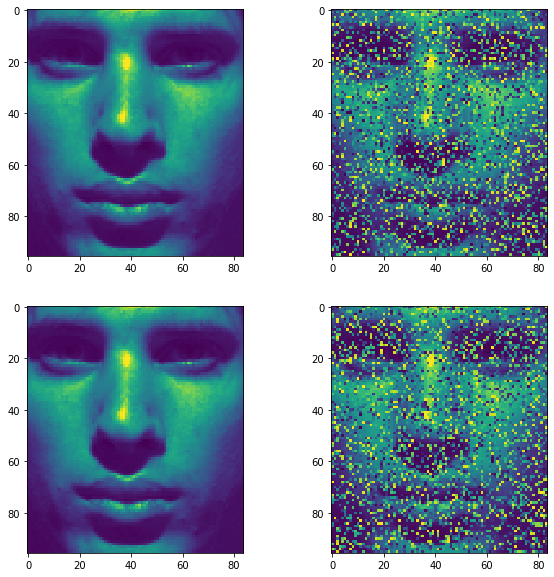

In [31]:
perc = 0.4
k = 1

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(y_ds[:,k].reshape(y_ds_sh))
plt.subplot(222)
plt.imshow(corrupt(y_ds, perc)[:,k].reshape(y_ds_sh))
plt.subplot(223)
plt.imshow(y_wave[:,k].reshape(y_wave_sh))
plt.subplot(224)
plt.imshow(corrupt(y_wave, perc)[:,k].reshape(y_wave_sh))
plt.show()

In [182]:
@ignore_warnings(category=ConvergenceWarning)
def robust_identity(A, B, y, class_idxs, lmbda=1e-12 verbose = False):
#     A_norm = np.linalg.norm(A, axis=0)
#     y_norm = np.linalg.norm(y)
    m,n = A.shape
#     B = np.hstack((A, np.eye(m)))
#     B_norm = np.linalg.norm(B, axis=0)
#     print(B.shape)
    prob = Lasso(fit_intercept=False, alpha=1e-12)
    prob.fit(B, y)
    w_hat = prob.coef_
    x_hat = w_hat[:n]
    e_hat = w_hat[n:]
    r = np.zeros(38)
    if verbose:
        print(f"Argwhere x_hat: {np.argwhere(x_hat>0.2)}")
    for i in range(38):
        r[i] = np.linalg.norm(y-e_hat-A@delta_i(x_hat, i, class_idxs))
    return np.argmin(r)

SyntaxError: invalid syntax (<ipython-input-182-24963d0963f8>, line 2)

In [183]:
def evaluate_robust(A, y, train_gt, test_gt, ld_func=down_samp, size_arg = None, lmbda = 1e-12, verbose = False):
    
    test_pred = np.ones_like(test_gt)*-1
    
    if ld_func.__name__ == "down_samp_pca":
        A_ld, pca = ld_func(A, size_arg)
        y_ld = pca.transform(y.T).T
    else:
        A_ld, _ = ld_func(A)
        y_ld, _ = ld_func(y)
    if verbose:
        print(f"Low Dim Shapes\n\tA: {A_ld.shape}\n\ty:{y_ld.shape}")

#     corrupt_percs = np.arange(0,1,0.1)
#     corrupt_percs = [0, 0.4, 0.6]
    corrupt_percs = [0]
    test_acc = []
    
    m,n = A_ld.shape
    B = np.hstack((A_ld, np.eye(m)))
    B = B/np.linalg.norm(B, axis=0)
    A_ld = A_ld/np.linalg.norm(A_ld, axis=0)
    for perc in corrupt_percs:
        corrupt_y = corrupt(y_ld, perc)
        corrupt_y = corrupt_y/np.linalg.norm(corrupt_y, axis=0)
        for i in tqdm(range(len(test_pred)), position=0, leave=True):
            test_pred[i] = robust_identity(A_ld, B, corrupt_y[:,i],train_gt,lmbda, verbose)

    #     print(train_pred)
        test_acc.append(accuracy_score(test_gt, test_pred)*100)
        
    
    print("Robust Identity Accuracy for {}:\n\tTest Accuracy: {}".format(ld_func.__name__, test_acc))
    return test_acc

In [194]:
#TODO: Change train and test data for robust
#TODO: Change ds factor for robust# Robust data read
train_cond = lambda az, elev: abs(az) <= 25 and abs(elev) <= 25
test_cond = lambda az, elev: 25 <= abs(az) <= 100 and 25 <= abs(elev) <= 65

A_cond, y_cond, train_gt_cond, test_gt_cond, names_cond = random_sample_cond(train_cond, test_cond)
samp_idxs = np.random.choice(len(test_gt_cond), size=100)
y_cond_samp = y_cond[:,samp_idxs]
test_gt_cond_samp = test_gt_cond[samp_idxs]

down_samp_funcs = {down_samp: [2, 4, 8, 16], down_samp_wave: [1, 2, 3, 4], down_samp_pca: [132, 504, 2016, 8064]}
lmbdas = [1e-12, 1e-9, 1e-6, 1e-3]
test_accs_normal = {"down_samp": [], "down_samp_wave": [], "down_samp_pca": []}
for func, levels in down_samp_funcs.items():
    for i, level in enumerate(levels):
        test_accs_normal[func.__name__].append(evaluate(A_cond, y_cond_samp, 
                                                   train_gt, test_gt_cond_samp,
                                                   ld_func=func, size_arg = level,
                                                   lmbda=lmbdas[i], train=False))
        


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy for down_samp:
	Test Accuracy: 72.00


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

Accuracy for down_samp:
	Test Accuracy: 72.00


  8%|▊         | 8/100 [00:00<00:01, 75.72it/s]

Accuracy for down_samp:
	Test Accuracy: 61.00


100%|██████████| 100/100 [00:01<00:00, 71.34it/s]


Accuracy for down_samp:
	Test Accuracy: 35.00


100%|██████████| 100/100 [08:19<00:00,  5.00s/it]


Accuracy for down_samp_wave:
	Test Accuracy: 74.00


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Accuracy for down_samp_wave:
	Test Accuracy: 75.00


100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


Accuracy for down_samp_wave:
	Test Accuracy: 67.00


100%|██████████| 100/100 [00:01<00:00, 58.47it/s]


Accuracy for down_samp_wave:
	Test Accuracy: 30.00


100%|██████████| 100/100 [00:01<00:00, 84.12it/s]


Accuracy for down_samp_pca:
	Test Accuracy: 7.00


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]

Accuracy for down_samp_pca:
	Test Accuracy: 43.00


ValueError: n_components=2016 must be between 0 and min(n_samples, n_features)=719 with svd_solver='full'

In [207]:
evaluate(A_cond, y_cond_samp, 
           train_gt, test_gt_cond_samp,
           ld_func=down_samp_pca, size_arg = 504,
           lmbda=9e-6, train=False)

100%|██████████| 100/100 [00:09<00:00, 10.60it/s]

Accuracy for down_samp_pca:
	Test Accuracy: 68.00


68.0

In [197]:
test_accs_normal = {"down_samp": [72.0, 72.0, 61.0, 35.0], 
                    "down_samp_wave": [74.0, 75.0, 67, 30.0]}

In [218]:
#TODO: Change train and test data for robust
#TODO: Change ds factor for robust# Robust data read

A, y, train_gt, test_gt, names = random_sample()
samp_idxs = np.random.choice(len(test_gt), size=100)
y_samp = y[:,samp_idxs]
test_gt_samp = test_gt[samp_idxs]

test_accs = {"down_samp": [], "down_samp_wave": []}
for func, levels in down_samp_funcs.items():
    for i, level in enumerate(levels):
        test_accs[func.__name__].append(evaluate(A, y_samp, 
                                                   train_gt, test_gt_samp,
                                                   ld_func=func, size_arg = level,
                                                   lmbda=lmbdas[i], train=False))
        


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy for down_samp:
	Test Accuracy: 97.00


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy for down_samp:
	Test Accuracy: 95.00


  6%|▌         | 6/100 [00:00<00:02, 46.03it/s]

Accuracy for down_samp:
	Test Accuracy: 96.00


100%|██████████| 100/100 [00:02<00:00, 42.30it/s]


Accuracy for down_samp:
	Test Accuracy: 86.00


100%|██████████| 100/100 [14:02<00:00,  8.42s/it]


Accuracy for down_samp_wave:
	Test Accuracy: 97.00


100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


Accuracy for down_samp_wave:
	Test Accuracy: 96.00


100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Accuracy for down_samp_wave:
	Test Accuracy: 96.00


100%|██████████| 100/100 [00:02<00:00, 36.48it/s]

Accuracy for down_samp_wave:
	Test Accuracy: 89.00


KeyError: 'down_samp_pca'

In [219]:
test_accs

{'down_samp': [97.0, 95.0, 96.0, 86.0],
 'down_samp_wave': [97.0, 96.0, 96.0, 89.0]}

In [173]:
a = {}
a['hello'] = 2

In [174]:
a

{'hello': 2}

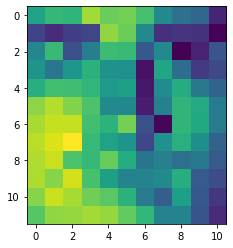

In [217]:
img = A_cond[:,0].reshape(im_size)
img_d = cv2.resize(img, (11,12))
img_u = cv2.resize(img, im_size[::-1])
plt.imshow(img_u)

In [210]:
cv2.resize?